# Oanda Demo Trading Notebook

## Packages

### Normal Packages

In [1]:
import numpy as np
import pandas as pd

import yaml
import json

import sys
import time
import pytz
import datetime
import winsound
import collections

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### Oanda Packages

In [2]:
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.trades as trades
import oandapyV20.endpoints.pricing as pricing
import oandapyV20.endpoints.accounts as accounts
import oandapyV20.endpoints.transactions as trans
import oandapyV20.endpoints.positions as positions

import oandapyV20.definitions.pricing as defpricing

import oandapyV20.endpoints.instruments as instruments

from oandapyV20.contrib.requests import (MarketOrderRequest, StopLossDetails)

### Custom packages

In [3]:
from utils.tools import get_date_time
from utils.tools import get_prices
from utils.tools import calc_duration

## Tools

In [4]:
def run_currency_num_check(accountID, currencies, iter_num):
    for i, instrument in enumerate(currencies['currs']):        
        pip_size = currencies['currs'][instrument]['pip_size']
        pip_gap = currencies['currs'][instrument]['pip_gap']
        num = get_min_trans_num(instrument, accountID, iter_num, pip_gap, pip_size)
        print(f'instrument : {instrument}, num : {num}, pip_size : {pip_size}')
    return()

In [5]:
def make_order(accountID, stop_price, instrument, units):
    stopLossOnFill = StopLossDetails(price=stop_price)

    ordr = MarketOrderRequest(
        instrument = instrument,
        units=units,
        stopLossOnFill=stopLossOnFill.data)

    r = orders.OrderCreate(accountID, data=ordr.data)
    rv = api.request(r)
    return(rv)

In [6]:
def close_order(accountID, order_type, instrument):
    data_long = {"longUnits": "ALL"}
    data_short = {"shortUnits": "ALL"}
    
    if order_type == 'long':
        data = data_long
    elif order_type == 'short':
        data = data_short
        
    r = positions.PositionClose(accountID=accountID,
                                instrument=instrument,
                                data=data)
    rv = api.request(r)
    return(rv)

In [7]:
def get_loss_limits(min_trans_num, loss_limits):
    dividing_val = 1
    per_list = list(loss_limits.keys())
    
    for i, val in enumerate(per_list):
        dividing_val = 100/val
        loss_limits[val]['half_min_trans_num'] = (round((min_trans_num/dividing_val),0))*(-1)
    return(loss_limits)

In [8]:
def get_min_trans_num(instrument,accountID,iter_num, pip_gap, pip_size):
    pip_gap = pip_gap * pip_size
    
    price_df = pd.DataFrame()
    diff = 0
    ticks = []
    iter_req = []
    params = {'instruments': instrument}

    r = pricing.PricingStream(accountID=accountID, params=params)
    rv = api.request(r)
    

    for i, resp in tqdm(enumerate(rv)):    
        resp_type = resp['type']
        if resp_type == 'HEARTBEAT': # Heart beat response to keep the api connection alive (Avoid timeout)
            pass

        else:
            if i < iter_num:
                date_val, time_val, time_fraction = get_date_time(resp) # Get time stamp for reference            
                sell_price, buy_price, spread, tick_price = get_prices(resp) # Get prices from the response                      
                ticks.append(tick_price)

            else:
                break

    price_df['tick_price'] = ticks


    for i, ival in enumerate(price_df['tick_price']):
        for j, jval in enumerate(price_df['tick_price']):
            if i == j:
                pass
            elif j > i:
                diff = abs(jval - ival)
                if diff >= pip_gap:
                    iter_req.append(j-i)
                    break
            else:
                pass
    
    #print(iter_req)
    min_trans = round(np.mean(iter_req),0)
    return(np.mean(min_trans))

## Direction Engine

In [9]:
def get_direction(df_reached_targets, target_num,  min_count, pip_position, min_count_mulitplier):
    tot_pos = sum(df_reached_targets['positive'] * df_reached_targets['target_num'])
    tot_neg = sum(df_reached_targets['negative'] * df_reached_targets['target_num'])

    if ((tot_pos+1) / (tot_neg+1)) > min_count and tot_pos > (round((min_count * min_count_mulitplier),0)) and df_reached_targets['positive'][pip_position] > 0:
        direction = 'positive'

    elif ((tot_neg+1) / (tot_pos+1)) > min_count and tot_neg > (round((min_count * min_count_mulitplier),0)) and df_reached_targets['negative'][pip_position] > 0:
        direction = 'negative'
        
    else:
        direction = 'no_direction'
    
    return(direction)

In [10]:
def get_targets(start_price, target_num, pip_size, pip_gap):
    positive_targets = {}
    negative_targets = {}
    
    for i in range(target_num):
        move_val = pip_size*(i+1)*pip_gap
        positive_targets[i] = start_price + move_val
        negative_targets[i] = start_price - move_val
        
    return(positive_targets, negative_targets)

In [11]:
def run_direction_engine(accountID, instrument, num, target_num, min_count, pip_size, pip_gap, min_count_mulitplier): 
    print(f'Finding Market Direction with min trans of {num}...')
    
    params = {'instruments': instrument}
    
    reached_targets = {'start_price' : 0,
                       'target_num' : 0,
                       'positive_val' : 0,
                       'negative_val' : 0,
                       'positive' : 0,
                       'p_duration' : '',
                       'n_duration' : '',
                       'negative' : 0}

    pos_target_flag = 'not_reached'
    neg_target_flag = 'not_reached'
    first_run_flag = 0
    #pip_position = pip_gap - 1
    pip_position = 0
    
    df_reached_targets = pd.DataFrame()
    tick_list = []

    
    
    r = pricing.PricingStream(accountID=accountID, params=params)
    rv = api.request(r)

    start_time = time.time()

    for i, resp in tqdm(enumerate(rv)):

        if i < num: # Check if we are within the required number of price iterations               
            resp_type = resp['type']       

            if resp_type == 'HEARTBEAT': # Heart beat response to keep the api connection alive (Avoid timeout)
                pass
                #print(resp_type)

            elif resp_type == 'PRICE': # Check whether it is a price response                 
                date_val, time_val, time_fraction = get_date_time(resp) # Get time stamp for reference            
                sell_price, buy_price, spread, tick_price = get_prices(resp) # Get prices from the response                      
                tick_list.append(tick_price)

                if first_run_flag == 0:
                    positive_targets, negative_targets = get_targets(tick_price, target_num, pip_size, pip_gap)
                    first_run_flag = 1
                    for j in range(target_num):
                        df_reached_targets = df_reached_targets.append(reached_targets, ignore_index = True)
                        df_reached_targets.loc[df_reached_targets.index[j], 'target_num'] = j+1
                        df_reached_targets.loc[df_reached_targets.index[j], 'start_price'] = tick_price
                        df_reached_targets.loc[df_reached_targets.index[j], 'positive_val'] = positive_targets[j]
                        df_reached_targets.loc[df_reached_targets.index[j], 'negative_val'] = negative_targets[j]

                for k in range(target_num):
                    if tick_price >= positive_targets[k]:
                        price_diff = tick_price - df_reached_targets.loc[df_reached_targets.index[k], 'start_price']
                        df_reached_targets.loc[df_reached_targets.index[k], 'positive'] += (price_diff * 10000)
                        
                        if pos_target_flag == 'not_reached':
                            end_time = time.time()    
                            duration = calc_duration(start_time, end_time)
                            df_reached_targets.loc[df_reached_targets.index[k], 'p_duration'] = duration
                            pos_target_flag = 'reached'

                    if tick_price <= negative_targets[k]:
                        price_diff = df_reached_targets.loc[df_reached_targets.index[k], 'start_price'] - tick_price
                        df_reached_targets.loc[df_reached_targets.index[k], 'negative'] += (price_diff * 10000)

                        if neg_target_flag == 'not_reached':
                            end_time = time.time()    
                            duration = calc_duration(start_time, end_time)
                            df_reached_targets.loc[df_reached_targets.index[k], 'n_duration'] = duration
                            neg_target_flag = 'reached'

        else: # Crossed the required number of price iterations
            try:
                r.terminate(message = "maxrecs records received")
            except:
                pass

    df_reached_targets =  df_reached_targets[['start_price', 'target_num', 'positive_val', 'negative_val','positive', 'negative','p_duration','n_duration']]

    df_reached_targets.loc[df_reached_targets.index[0], 'positive'] = df_reached_targets.loc[df_reached_targets.index[0], 'positive'] - df_reached_targets.loc[df_reached_targets.index[1], 'positive']
    df_reached_targets.loc[df_reached_targets.index[1], 'positive'] = df_reached_targets.loc[df_reached_targets.index[1], 'positive'] - df_reached_targets.loc[df_reached_targets.index[2], 'positive']
    df_reached_targets.loc[df_reached_targets.index[0], 'negative'] = df_reached_targets.loc[df_reached_targets.index[0], 'negative'] - df_reached_targets.loc[df_reached_targets.index[1], 'negative']
    df_reached_targets.loc[df_reached_targets.index[1], 'negative'] = df_reached_targets.loc[df_reached_targets.index[1], 'negative'] - df_reached_targets.loc[df_reached_targets.index[2], 'negative']
    
    direction = get_direction(df_reached_targets, target_num, min_count, pip_position, min_count_mulitplier)

    #winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC) 
    return(direction, df_reached_targets, tick_list)

In [12]:
def run_order_engine(accountID, instrument, direction, profit_target_num, loss_limit_num, price_allowed_buff, min_trans_num, pip_size, loss_limits):    
    
    params = {'instruments': instrument}
    r = pricing.PricingStream(accountID=accountID, params=params)
    rv = api.request(r)
    order_flag = 'not_ordered'
    first_long = True
    first_short = True
    profit_moves = 0
    
    profit_target = profit_target_num * pip_size
    loss_limit = loss_limit_num * pip_size
    price_allowed_buffer = price_allowed_buff * pip_size

    loss_limits_dict = get_loss_limits(min_trans_num, loss_limits)
    print('Running OE : ', min_trans_num, loss_limits)
    
    for i, resp in tqdm(enumerate(rv)):        
        open_positions_r = positions.OpenPositions(accountID=accountID)
        open_positions_rv = api.request(open_positions_r)
        open_positions = len(open_positions_rv['positions'])        
        resp_type = resp['type']       
        
        if resp_type == 'HEARTBEAT': # Heart beat response to keep the api connection alive (Avoid timeout)
            pass
        
        elif resp_type == 'PRICE' and order_flag == 'not_ordered': # Check if we are yet to make the order               
            date_val, time_val, time_fraction = get_date_time(resp) # Get time stamp for reference            
            sell_price, buy_price, spread, tick_price = get_prices(resp) # Get prices from the response                      

            if direction == 'positive':
                order_type = 'long'
                units = +1
                #stop_price = sell_price - loss_limit
                stop_price = buy_price - loss_limit                
                make_order_log = make_order(accountID, stop_price, instrument, units)
                order_flag = 'ordered'

            elif direction == 'negative':
                order_type = 'short'
                units = -1                    
                #stop_price = buy_price + loss_limit
                stop_price = sell_price + loss_limit                
                make_order_log = make_order(accountID, stop_price, instrument, units)                    
                order_flag = 'ordered'

        elif resp_type == 'PRICE' and order_flag == 'ordered' and open_positions == 1: # Check if we have made the order
            sell_price, buy_price, spread, tick_price = get_prices(resp) # Get prices from the response                                      

            if order_type == 'long':     
                ordered_buy_price = float(make_order_log['orderFillTransaction']['fullPrice']['asks'][0]['price'])
                profit = sell_price - ordered_buy_price 
                
                if first_long:
                    max_price = sell_price
                    first_long = False
                
                max_price = max(sell_price, max_price)
                buffered_max_price = max_price - price_allowed_buffer
                buffered_max_price = max(profit_target, buffered_max_price)
                
                if profit > 0:
                    profit_moves += 1
                elif profit < 0:
                    profit_moves -= 1                    
                               
                if profit >= profit_target and sell_price <= buffered_max_price:    
                    close_order_log = close_order(accountID, order_type ,instrument)
                    order_flag = 'closed'
                    close_reason = "Take_profit"
                    
                if i > min_trans_num and profit_moves < 0 and order_flag != 'closed':
                    close_order_log = close_order(accountID, order_type ,instrument)
                    order_flag = 'closed'           
                    close_reason = "Min trans moves"

                for _, val in enumerate(list(loss_limits.keys())):
                    #print(f"profit_moves:{profit_moves}, loss_lim:{loss_limits_dict[val]['half_min_trans_num']}, profit:{profit}, max_loss:{loss_limits_dict[val]['max_loss']}")
                    if profit_moves <= loss_limits_dict[val]['half_min_trans_num'] and order_flag != 'closed' and profit >= loss_limits_dict[val]['max_loss']:
                        close_order_log = close_order(accountID, order_type ,instrument)
                        order_flag = 'closed'           
                        close_reason = f'{val} Neg half min trans'
                        
                        
                #print(f'ordered_buy_price:{ordered_buy_price} \n max_price:{max_price} \n buffered_max_price:{buffered_max_price} \n sell_price:{sell_price} \n profit:{profit}')
                    
                    
            if order_type == 'short':     
                ordered_sell_price = float(make_order_log['orderFillTransaction']['fullPrice']['bids'][0]['price'])
                profit = ordered_sell_price - buy_price                

                if first_short:
                    min_price = buy_price
                    first_short = False
                
                min_price = min(buy_price, min_price)
                buffered_min_price = min_price + price_allowed_buffer
                buffered_min_price = min(profit_target, buffered_min_price)

                if profit > 0:
                    profit_moves += 1
                elif profit < 0:
                    profit_moves -= 1                    
                    
                if profit >= profit_target and buy_price >= buffered_min_price:
                    close_order_log = close_order(accountID, order_type ,instrument)
                    order_flag = 'closed'
                    close_reason = "Take_profit"
                    
                    
                if i > min_trans_num and profit_moves < 0 and order_flag != 'closed':
                    close_order_log = close_order(accountID, order_type ,instrument)
                    order_flag = 'closed' 
                    close_reason = "Min trans moves"

                    
                for _, val in enumerate(list(loss_limits.keys())):
                    #print(f"profit_moves:{profit_moves}, loss_lim:{loss_limits_dict[val]['half_min_trans_num']}, profit:{profit}, max_loss:{loss_limits_dict[val]['max_loss']}")
                    if profit_moves <= loss_limits_dict[val]['half_min_trans_num'] and order_flag != 'closed' and profit >= loss_limits_dict[val]['max_loss']:
                        close_order_log = close_order(accountID, order_type ,instrument)
                        order_flag = 'closed'           
                        close_reason = f'{val} Neg half min trans'

                #print(f'ordered_sell_price:{ordered_sell_price} \n min_price:{min_price} \n buffered_min_price:{buffered_min_price} \n sell_price:{sell_price} \n profit:{profit}')
                        
                    
        elif resp_type == 'PRICE' and (order_flag == 'closed' or open_positions == 0): # Check if we have made the order
            try:
                if order_flag != 'closed':
                    close_order_log = 'stop_loss_trigger'
                    close_reason = 'stop_loss'                    
                r.terminate(message = "")
                
            except:
                pass

    return(make_order_log, close_order_log, i, close_reason)

In [13]:
def get_output_data(accountID, instrument, make_order_log, close_order_log, iters, close_reason, dirc):
    output_data = {'date':[],
                   'time':[],
                   'instrument':[],
                   'direction':[],                   
                   'ordr_type':[],                   
                   'units':[],
                   'profit_pips':[],
                   'close_reason':[],
                   'Iterations':[],                   
                   'orderID':[]
                  }
    

    if dirc:    
        # Make_Order_Log
        #-------------------------------------------------
        make_dict_key = list(make_order_log.keys())[1]
        uni = int(make_order_log[make_dict_key]['units'])
        if uni > 0:
            output_data['ordr_type'] = 'long'
            output_data['direction'] = 'positive'
        else:
            output_data['ordr_type'] = 'short'
            output_data['direction'] = 'negative'        


        # Close_Order_Log
        #-------------------------------------------------        
        if close_order_log != 'stop_loss_trigger':    
            close_dict_key= list(close_order_log.keys())[1]
            dt, tm, _ = get_date_time(close_order_log[close_dict_key])
            output_data['date'].append(dt)  
            output_data['time'].append(tm)
            output_data['instrument'].append(close_order_log[close_dict_key]['instrument'])
            output_data['units'].append(uni)
            output_data['profit_pips'].append(close_order_log[close_dict_key]['pl'])
            output_data['orderID'].append(close_order_log[close_dict_key]['orderID'])
            output_data['close_reason'].append(close_reason)
            output_data['Iterations'].append(iters)



        # Stop_Order_Logging
        #-------------------------------------------------
        elif close_order_log == 'stop_loss_trigger':
            last_position_r = positions.PositionDetails(accountID, instrument)
            last_position_rv = api.request(last_position_r)
            last_transaction_id = last_position_rv['lastTransactionID']

            transaction_details_r = trans.TransactionDetails(accountID, transactionID=last_transaction_id)
            transaction_details_rv = api.request(transaction_details_r)

            time_stamp = transaction_details_rv['transaction']['fullPrice']['timestamp']
            dt, full_time = time_stamp.split(sep = 'T')
            tm, time_fraction = full_time.split(sep = '.')
            inst = transaction_details_rv['transaction']['instrument']
            #unts = transaction_details_rv['transaction']['units']
            prfit_pips = transaction_details_rv['transaction']['pl']
            clse_reason = transaction_details_rv['transaction']['reason']
            ordrID = transaction_details_rv['transaction']['orderID']

            output_data['date'].append(dt)  
            output_data['time'].append(tm)
            output_data['instrument'].append(inst)
            output_data['units'].append(uni)
            output_data['profit_pips'].append(prfit_pips)
            output_data['orderID'].append(ordrID)
            output_data['close_reason'].append(close_reason)
            output_data['Iterations'].append(iters)  
            
            
    elif dirc == False:
        d = datetime.datetime.utcnow()
        d_with_timezone = d.replace(tzinfo=pytz.UTC)
        time_stamp = d_with_timezone.isoformat()
        dt_now, full_time = time_stamp.split(sep = 'T')
        tm_now, time_fraction = full_time.split(sep = '.')

        output_data['date'].append(dt_now)  
        output_data['time'].append(tm_now)
        output_data['instrument'].append(instrument)
        output_data['direction'] = 'no_direction'        
        output_data['ordr_type'].append('')
        output_data['units'].append('')
        output_data['profit_pips'].append('')
        output_data['orderID'].append('')
        output_data['close_reason'].append('')
        output_data['Iterations'].append('') 

        
    # Write to Dataframe
    #-------------------------------------------------    
    output_df = pd.DataFrame()
    output_df = pd.DataFrame.from_dict(output_data)
    output_df = output_df[['date', 'time', 'instrument', 'direction', 'ordr_type','units', 'profit_pips', 'close_reason', 'Iterations','orderID']]

    return(output_df)

In [14]:
def switch_direction(direction):
    if direction == 'positive':
        return('negative')
    elif direction == 'negative':
        return('positive')

## API Setup

Read from config file

In [15]:
temp_file = 'config/access_keys.yaml'
with open(temp_file) as temp_file:
    config = yaml.load(temp_file)
    
temp_file = 'config/currencies.yaml'
with open(temp_file) as temp_file:
    currencies = yaml.load(temp_file)

temp_file = 'config/stepped_loss.yaml'
with open(temp_file) as temp_file:
    loss_limits = yaml.load(temp_file)

In [16]:
access_token = config['oanda_demo_account']['token']
accountID = config['oanda_demo_account']['account_id']
api = API(access_token = access_token)

## Code Engine

# Log these inputs as well

In [17]:
# max_loss_num = 1
# full_loss_ratio = 10


instrument="EUR_USD"
pip_size = currencies['currs'][instrument]['pip_size']
pip_gap = currencies['currs'][instrument]['pip_gap']

profit_target_num  = 0.5
price_allowed_buffer = 0.5 
loss_limit_num = 25


target_num = 3
min_count = 2
min_count_mulitplier = 1


iter_num = 300
dir_min_trans_multiplier_long = 1
dir_min_trans_multiplier_short = 0.5

run_min_trans_multiplier = 25
dir_recalc_multiplier = 5

num_of_bets = 10

In [18]:
%%time
#num = 25
num = get_min_trans_num(instrument, accountID, iter_num, pip_gap, pip_size)
dir_min_trans_num_long = round((num * dir_min_trans_multiplier_long),0)
dir_min_trans_num_short = round((num * dir_min_trans_multiplier_short),0)
dir_min_trans_num = dir_min_trans_num_long

run_min_trans_num = round((num * run_min_trans_multiplier),0)

run_flag = True

for i in range(num_of_bets):    
    print(f'-------------------------------Iteration {i+1}-------------------------------')
    if run_flag:
        direction, df_reached_targets, tick_list = run_direction_engine(accountID, instrument, dir_min_trans_num, target_num, min_count, pip_size, pip_gap, min_count_mulitplier)    
        print('df_reached_targets : ',df_reached_targets)
        
    if direction == 'no_direction':
        print('no_direction : Run again')
        run_flag = True
        dir_min_trans_num = dir_min_trans_num_long
        output_df = get_output_data('', '', '', '', '', '',dirc = False) 
        
    else:
        print(f'Direction : {direction}')
        make_order_log, close_order_log, iters, close_reason = run_order_engine(accountID, instrument, direction, profit_target_num, loss_limit_num, price_allowed_buffer, run_min_trans_num, pip_size, loss_limits)
        output_df = get_output_data(accountID, instrument, make_order_log, close_order_log, iters, close_reason, dirc = True)
        pl_pip = float(output_df['profit_pips'])
        iter_limit = dir_min_trans_num * dir_recalc_multiplier
        print(f'pl:{pl_pip} iter_limit:{iter_limit}')


        if float(pl_pip) >= 0 and iters < iter_limit:
            run_flag = True
            dir_min_trans_num = dir_min_trans_num_short
        else:
            run_flag = True
            dir_min_trans_num = dir_min_trans_num_long

    output_df.to_csv('data/machine_use/output_log_machine_use.csv', mode='a', header=False, index = False)

301it [09:10,  1.83s/it]
0it [00:00, ?it/s]

-------------------------------Iteration 1-------------------------------
Finding Market Direction with min trans of 23.0...


24it [01:05,  2.72s/it]
0it [00:00, ?it/s]

df_reached_targets :     start_price  target_num  positive_val  negative_val  positive  negative  \
0      1.12704         1.0       1.12714       1.12694       0.0       0.0   
1      1.12704         2.0       1.12724       1.12684       0.0       0.0   
2      1.12704         3.0       1.12734       1.12674       0.0       0.0   

  p_duration n_duration  
0                        
1                        
2                        
no_direction : Run again
-------------------------------Iteration 2-------------------------------
Finding Market Direction with min trans of 23.0...


24it [00:22,  1.09it/s]
0it [00:00, ?it/s]

df_reached_targets :     start_price  target_num  positive_val  negative_val  positive  negative  \
0      1.12702         1.0       1.12712       1.12692       0.0      7.65   
1      1.12702         2.0       1.12722       1.12682       0.0      0.00   
2      1.12702         3.0       1.12732       1.12672       0.0      0.00   

  p_duration n_duration  
0                0:0:15  
1                        
2                        
Direction : negative
Running OE :  575.0 {50: {'half_min_trans_num': -288.0, 'max_loss': -0.0001}, 60: {'half_min_trans_num': -345.0, 'max_loss': -0.0002}, 70: {'half_min_trans_num': -402.0, 'max_loss': -0.0003}, 80: {'half_min_trans_num': -460.0, 'max_loss': -0.0004}}


130it [03:31,  1.63s/it]
0it [00:00, ?it/s]

pl:0.0001 iter_limit:115.0
-------------------------------Iteration 3-------------------------------
Finding Market Direction with min trans of 23.0...


24it [00:53,  2.21s/it]
0it [00:00, ?it/s]

df_reached_targets :     start_price  target_num  positive_val  negative_val  positive  negative  \
0      1.12662         1.0       1.12672       1.12652       0.0       0.0   
1      1.12662         2.0       1.12682       1.12642       0.0       0.0   
2      1.12662         3.0       1.12692       1.12632       0.0       0.0   

  p_duration n_duration  
0                        
1                        
2                        
no_direction : Run again
-------------------------------Iteration 4-------------------------------
Finding Market Direction with min trans of 23.0...


24it [00:39,  1.65s/it]
0it [00:00, ?it/s]

df_reached_targets :     start_price  target_num  positive_val  negative_val  positive  negative  \
0      1.12662         1.0       1.12672       1.12652       0.0      1.05   
1      1.12662         2.0       1.12682       1.12642       0.0      0.00   
2      1.12662         3.0       1.12692       1.12632       0.0      0.00   

  p_duration n_duration  
0                0:0:39  
1                        
2                        
no_direction : Run again
-------------------------------Iteration 5-------------------------------
Finding Market Direction with min trans of 23.0...


24it [00:53,  2.25s/it]
0it [00:00, ?it/s]

df_reached_targets :     start_price  target_num  positive_val  negative_val  positive  negative  \
0     1.126535         1.0      1.126635      1.126435      5.55       0.0   
1     1.126535         2.0      1.126735      1.126335      0.00       0.0   
2     1.126535         3.0      1.126835      1.126235      0.00       0.0   

  p_duration n_duration  
0     0:0:53             
1                        
2                        
Direction : positive
Running OE :  575.0 {50: {'half_min_trans_num': -288.0, 'max_loss': -0.0001}, 60: {'half_min_trans_num': -345.0, 'max_loss': -0.0002}, 70: {'half_min_trans_num': -402.0, 'max_loss': -0.0003}, 80: {'half_min_trans_num': -460.0, 'max_loss': -0.0004}}


106it [03:39,  2.07s/it]
0it [00:00, ?it/s]

pl:0.0001 iter_limit:115.0
-------------------------------Iteration 6-------------------------------
Finding Market Direction with min trans of 12.0...


13it [00:19,  1.53s/it]
0it [00:00, ?it/s]

df_reached_targets :     start_price  target_num  positive_val  negative_val  positive  negative  \
0      1.12679         1.0       1.12689       1.12669       0.0       0.0   
1      1.12679         2.0       1.12699       1.12659       0.0       0.0   
2      1.12679         3.0       1.12709       1.12649       0.0       0.0   

  p_duration n_duration  
0                        
1                        
2                        
no_direction : Run again
-------------------------------Iteration 7-------------------------------
Finding Market Direction with min trans of 23.0...


24it [00:37,  1.58s/it]
0it [00:00, ?it/s]

df_reached_targets :     start_price  target_num  positive_val  negative_val  positive  negative  \
0      1.12683         1.0       1.12693       1.12673       0.0       0.0   
1      1.12683         2.0       1.12703       1.12663       0.0       0.0   
2      1.12683         3.0       1.12713       1.12653       0.0       0.0   

  p_duration n_duration  
0                        
1                        
2                        
no_direction : Run again
-------------------------------Iteration 8-------------------------------
Finding Market Direction with min trans of 23.0...


24it [00:38,  1.61s/it]
0it [00:00, ?it/s]

df_reached_targets :     start_price  target_num  positive_val  negative_val  positive  negative  \
0     1.126825         1.0      1.126925      1.126725       0.0       0.0   
1     1.126825         2.0      1.127025      1.126625       0.0       0.0   
2     1.126825         3.0      1.127125      1.126525       0.0       0.0   

  p_duration n_duration  
0                        
1                        
2                        
no_direction : Run again
-------------------------------Iteration 9-------------------------------
Finding Market Direction with min trans of 23.0...


24it [00:18,  1.27it/s]
0it [00:00, ?it/s]

df_reached_targets :     start_price  target_num  positive_val  negative_val  positive  negative  \
0     1.126935         1.0      1.127035      1.126835       1.0       0.0   
1     1.126935         2.0      1.127135      1.126735       0.0       0.0   
2     1.126935         3.0      1.127235      1.126635       0.0       0.0   

  p_duration n_duration  
0     0:0:18             
1                        
2                        
no_direction : Run again
-------------------------------Iteration 10-------------------------------
Finding Market Direction with min trans of 23.0...


24it [00:51,  2.15s/it]
0it [00:00, ?it/s]

df_reached_targets :     start_price  target_num  positive_val  negative_val  positive  negative  \
0      1.12702         1.0       1.12712       1.12692       0.0      10.0   
1      1.12702         2.0       1.12722       1.12682       0.0       0.0   
2      1.12702         3.0       1.12732       1.12672       0.0       0.0   

  p_duration n_duration  
0                0:0:16  
1                        
2                        
Direction : negative
Running OE :  575.0 {50: {'half_min_trans_num': -288.0, 'max_loss': -0.0001}, 60: {'half_min_trans_num': -345.0, 'max_loss': -0.0002}, 70: {'half_min_trans_num': -402.0, 'max_loss': -0.0003}, 80: {'half_min_trans_num': -460.0, 'max_loss': -0.0004}}


345it [11:29,  2.00s/it]

pl:0.0001 iter_limit:115.0
Wall time: 34min 32s


In [19]:
df_copy = pd.read_csv('data/machine_use/output_log_machine_use.csv')
df_copy.to_csv('data/output_log.csv', index = False)    

In [20]:
'''
%%time
iter_nums = [100, 200]
for iter_num in iter_nums:
    run_currency_num_check(accountID, currencies, iter_num)
    '''

'\n%%time\niter_nums = [100, 200]\nfor iter_num in iter_nums:\n    run_currency_num_check(accountID, currencies, iter_num)\n    '

In [19]:
list = [120, 130, 110, 140, 110, 130]

df = pd.DataFrame(data = list, columns = ['price'])
df

,price
0,120
1,130
2,110
3,140
4,110
5,130


In [34]:
import math

In [35]:
math.sqrt(4)

2.0

In [75]:
s =  20

n = round((((-1) + (math.sqrt(8*s + 1)))/2),0)
n

6.0

In [100]:
wgts = get_weights(100)
sum(wgts)

1.0000000000000007

In [26]:
data = {'colA': [120, 130, 110, 140, 110, 130]}
df = pd.DataFrame(data)

small_weights = np.array([0.2, 0.3, 0.5])
small_weights = np.array([0.2, 0.3, 0.5])
sum_weights = np.sum(weights)

df['weighted_ma'] = (df['colA'].rolling(window=3, center=False).apply(lambda x: np.sum(weights*x) / sum_weights, raw=False))

df

,colA,weighted_ma
0,120,NaN
1,130,NaN
2,110,118.0
3,140,129.0
4,110,119.0
5,130,126.0


In [119]:
params = {'instruments': instrument}
order_flag = 'not_ordered'
r = pricing.PricingStream(accountID=accountID, params=params)
rv = api.request(r)

short_list = collections.deque([])
short_wma = 0

short_moving_window = 3
short_weights = get_weights(short_moving_window)
first_run = True

for i, resp in tqdm(enumerate(rv)):        
    resp_type = resp['type']       

    if resp_type == 'HEARTBEAT': # Heart beat response to keep the api connection alive (Avoid timeout)
        print('heart beat')
        pass

    elif resp_type == 'PRICE' and order_flag == 'not_ordered': # Check if we are yet to make the order               
        date_val, time_val, time_fraction = get_date_time(resp) # Get time stamp for reference            
        sell_price, buy_price, spread, tick_price = get_prices(resp) # Get prices from the response                      
        
        
        if len(short_list) < short_moving_window:
            short_list.append(tick_price)
        elif first_run:
            short_wma = sum(np.array(short_list)*short_weights)
            #print(short_list, '---' ,short_wma)
            first_run =  False
        else:
            short_list.popleft()   
            short_list.append(tick_price) 
            short_wma = sum(np.array(short_list)*short_weights)
            #print(short_list, '---' ,short_wma)

4it [00:06,  1.82s/it]

heart beat


7it [00:11,  1.84s/it]

heart beat


16it [00:16,  1.11it/s]

heart beat


24it [00:21,  1.11it/s]


KeyboardInterrupt: 

In [23]:
def get_weights(s):
    n = 1/s
    val = 0
    val_list = []
    for i in range(s):
        val += n
        val_list.append(val)
    val_list = np.array(val_list)
    tot = sum(val_list)
    val_list = val_list/tot
    return(val_list)

In [39]:
params = {'instruments': instrument}
order_flag = 'not_ordered'
r = pricing.PricingStream(accountID=accountID, params=params)
rv = api.request(r)

short_wma = 0
short_flag = True
short_moving_window = 20
short_list = collections.deque([])
short_wma_list = collections.deque([])
short_weights = get_weights(short_moving_window)

long_wma = 0
long_flag = True
long_moving_window = 100
long_list = collections.deque([])
long_wma_list = collections.deque([])
long_weights = get_weights(long_moving_window)

lists_size = 100

for i, resp in tqdm(enumerate(rv)):        
    resp_type = resp['type']       

    if resp_type == 'HEARTBEAT': # Heart beat response to keep the api connection alive (Avoid timeout)
        pass

    elif resp_type == 'PRICE' and order_flag == 'not_ordered': # Check if we are yet to make the order               
        date_val, time_val, time_fraction = get_date_time(resp) # Get time stamp for reference            
        sell_price, buy_price, spread, tick_price = get_prices(resp) # Get prices from the response                      
        
        if len(short_list) < short_moving_window:
            short_list.append(tick_price)
            
        if short_flag and len(short_list) == short_moving_window:
            short_wma = sum(np.array(short_list)*short_weights)
            short_flag =  False
            
        if short_flag == False and len(short_list) == short_moving_window:
            short_list.popleft()   
            short_list.append(tick_price) 
            short_wma = sum(np.array(short_list)*short_weights)
        
        if len(short_list) == short_moving_window:
            if len(short_wma_list) < lists_size:
                short_wma_list.append(short_wma)
                
            elif len(short_wma_list) == lists_size:
                short_wma_list.popleft()   
                short_wma_list.append(short_wma) 
        
        print(f'short_wma_list : {len(short_wma_list)}')
                
        if len(long_list) < long_moving_window:
            long_list.append(tick_price)
            
        if long_flag and len(long_list) == long_moving_window:
            long_wma = sum(np.array(long_list)*long_weights)
            long_flag =  False
            
        if long_flag == False and len(long_list) == long_moving_window:
            long_list.popleft()   
            long_list.append(tick_price) 
            long_wma = sum(np.array(long_list)*long_weights)
        
        if len(long_list) == long_moving_window:
            if len(long_wma_list) < lists_size:
                long_wma_list.append(long_wma)
                
            elif len(long_wma_list) == lists_size:
                #long_wma_list.popleft()   
                #long_wma_list.append(long_wma)                 
                break
              
        print(f'long_wma_list : {len(long_wma_list)}')
              
winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)           

1it [00:01,  1.15s/it]

short_wma_list : 0
long_wma_list : 0


2it [00:01,  1.14it/s]

short_wma_list : 0
long_wma_list : 0


3it [00:01,  1.45it/s]

short_wma_list : 0
long_wma_list : 0


4it [00:01,  1.79it/s]

short_wma_list : 0
long_wma_list : 0


5it [00:02,  1.86it/s]

short_wma_list : 0
long_wma_list : 0


6it [00:02,  2.21it/s]

short_wma_list : 0
long_wma_list : 0


8it [00:06,  1.19s/it]

short_wma_list : 0
long_wma_list : 0


9it [00:07,  1.10it/s]

short_wma_list : 0
long_wma_list : 0


10it [00:07,  1.16it/s]

short_wma_list : 0
long_wma_list : 0


11it [00:08,  1.21it/s]

short_wma_list : 0
long_wma_list : 0


12it [00:08,  1.53it/s]

short_wma_list : 0
long_wma_list : 0


14it [00:11,  1.24it/s]

short_wma_list : 0
long_wma_list : 0


15it [00:11,  1.57it/s]

short_wma_list : 0
long_wma_list : 0


16it [00:11,  1.68it/s]

short_wma_list : 0
long_wma_list : 0


17it [00:12,  1.56it/s]

short_wma_list : 0
long_wma_list : 0


18it [00:12,  1.91it/s]

short_wma_list : 0
long_wma_list : 0


19it [00:13,  1.93it/s]

short_wma_list : 0
long_wma_list : 0


20it [00:13,  2.28it/s]

short_wma_list : 0
long_wma_list : 0


21it [00:13,  2.62it/s]

short_wma_list : 0
long_wma_list : 0


22it [00:14,  2.93it/s]

short_wma_list : 1
long_wma_list : 0


23it [00:14,  2.15it/s]

short_wma_list : 2
long_wma_list : 0


24it [00:15,  1.82it/s]

short_wma_list : 3
long_wma_list : 0


25it [00:15,  2.18it/s]

short_wma_list : 4
long_wma_list : 0


27it [00:16,  3.14it/s]

short_wma_list : 5
long_wma_list : 0


28it [00:16,  3.89it/s]

short_wma_list : 6
long_wma_list : 0


29it [00:16,  3.92it/s]

short_wma_list : 7
long_wma_list : 0


30it [00:16,  3.96it/s]

short_wma_list : 8
long_wma_list : 0


31it [00:17,  2.49it/s]

short_wma_list : 9
long_wma_list : 0


32it [00:17,  2.80it/s]

short_wma_list : 10
long_wma_list : 0


33it [00:18,  1.81it/s]

short_wma_list : 11
long_wma_list : 0


34it [00:20,  1.20it/s]

short_wma_list : 12
long_wma_list : 0


35it [00:21,  1.23it/s]

short_wma_list : 13
long_wma_list : 0


37it [00:23,  1.04s/it]

short_wma_list : 14
long_wma_list : 0


38it [00:25,  1.25s/it]

short_wma_list : 15
long_wma_list : 0


39it [00:25,  1.05it/s]

short_wma_list : 16
long_wma_list : 0


41it [00:26,  1.23it/s]

short_wma_list : 17
long_wma_list : 0


42it [00:27,  1.39it/s]

short_wma_list : 18
long_wma_list : 0


43it [00:27,  1.53it/s]

short_wma_list : 19
long_wma_list : 0


44it [00:28,  1.64it/s]

short_wma_list : 20
long_wma_list : 0


45it [00:28,  1.99it/s]

short_wma_list : 21
long_wma_list : 0


46it [00:29,  1.99it/s]

short_wma_list : 22
long_wma_list : 0


47it [00:30,  1.54it/s]

short_wma_list : 23
long_wma_list : 0


48it [00:30,  1.65it/s]

short_wma_list : 24
long_wma_list : 0


49it [00:31,  1.74it/s]

short_wma_list : 25
long_wma_list : 0


51it [00:31,  2.22it/s]

short_wma_list : 26
long_wma_list : 0


52it [00:32,  2.56it/s]

short_wma_list : 27
long_wma_list : 0


53it [00:33,  1.75it/s]

short_wma_list : 28
long_wma_list : 0


54it [00:33,  2.10it/s]

short_wma_list : 29
long_wma_list : 0


55it [00:34,  1.58it/s]

short_wma_list : 30
long_wma_list : 0


56it [00:35,  1.22it/s]

short_wma_list : 31
long_wma_list : 0


57it [00:35,  1.54it/s]

short_wma_list : 32
long_wma_list : 0


58it [00:36,  1.89it/s]

short_wma_list : 33
long_wma_list : 0


60it [00:41,  1.78s/it]

short_wma_list : 34
long_wma_list : 0


61it [00:41,  1.32s/it]

short_wma_list : 35
long_wma_list : 0


63it [00:43,  1.22s/it]

short_wma_list : 36
long_wma_list : 0


66it [00:52,  2.02s/it]

short_wma_list : 37
long_wma_list : 0


67it [00:52,  1.46s/it]

short_wma_list : 38
long_wma_list : 0


68it [00:53,  1.40s/it]

short_wma_list : 39
long_wma_list : 0


69it [00:53,  1.05s/it]

short_wma_list : 40
long_wma_list : 0


70it [00:54,  1.22it/s]

short_wma_list : 41
long_wma_list : 0


71it [00:54,  1.56it/s]

short_wma_list : 42
long_wma_list : 0


72it [00:55,  1.33it/s]

short_wma_list : 43
long_wma_list : 0


73it [00:55,  1.67it/s]

short_wma_list : 44
long_wma_list : 0


75it [00:57,  1.39it/s]

short_wma_list : 45
long_wma_list : 0


76it [00:58,  1.49it/s]

short_wma_list : 46
long_wma_list : 0


77it [00:58,  1.83it/s]

short_wma_list : 47
long_wma_list : 0


78it [00:58,  2.19it/s]

short_wma_list : 48
long_wma_list : 0


79it [00:58,  2.54it/s]

short_wma_list : 49
long_wma_list : 0


80it [01:00,  1.38it/s]

short_wma_list : 50
long_wma_list : 0


81it [01:00,  1.71it/s]

short_wma_list : 51
long_wma_list : 0


82it [01:02,  1.17it/s]

short_wma_list : 52
long_wma_list : 0


84it [01:02,  1.69it/s]

short_wma_list : 53
long_wma_list : 0


85it [01:03,  1.40it/s]

short_wma_list : 54
long_wma_list : 0


86it [01:04,  1.54it/s]

short_wma_list : 55
long_wma_list : 0


87it [01:07,  1.28s/it]

short_wma_list : 56
long_wma_list : 0


88it [01:07,  1.03it/s]

short_wma_list : 57
long_wma_list : 0


90it [01:07,  1.68it/s]

short_wma_list : 58
long_wma_list : 0


91it [01:08,  1.76it/s]

short_wma_list : 59
long_wma_list : 0


92it [01:08,  1.83it/s]

short_wma_list : 60
long_wma_list : 0


93it [01:09,  1.87it/s]

short_wma_list : 61
long_wma_list : 0


94it [01:09,  2.22it/s]

short_wma_list : 62
long_wma_list : 0


95it [01:10,  1.86it/s]

short_wma_list : 63
long_wma_list : 0


96it [01:10,  2.20it/s]

short_wma_list : 64
long_wma_list : 0


97it [01:10,  2.56it/s]

short_wma_list : 65
long_wma_list : 0


98it [01:11,  2.36it/s]

short_wma_list : 66
long_wma_list : 0


99it [01:12,  1.68it/s]

short_wma_list : 67
long_wma_list : 0


101it [01:13,  2.04it/s]

short_wma_list : 68
long_wma_list : 0


102it [01:13,  2.41it/s]

short_wma_list : 69
long_wma_list : 0


103it [01:13,  2.26it/s]

short_wma_list : 70
long_wma_list : 0


104it [01:14,  1.87it/s]

short_wma_list : 71
long_wma_list : 0


105it [01:17,  1.13s/it]

short_wma_list : 72
long_wma_list : 0


107it [01:17,  1.37it/s]

short_wma_list : 73
long_wma_list : 0


108it [01:18,  1.72it/s]

short_wma_list : 74
long_wma_list : 0


109it [01:18,  2.08it/s]

short_wma_list : 75
long_wma_list : 0


110it [01:20,  1.01s/it]

short_wma_list : 76
long_wma_list : 0


111it [01:20,  1.28it/s]

short_wma_list : 77
long_wma_list : 0


112it [01:21,  1.61it/s]

short_wma_list : 78
long_wma_list : 0


113it [01:21,  1.71it/s]

short_wma_list : 79
long_wma_list : 0


114it [01:21,  2.05it/s]

short_wma_list : 80
long_wma_list : 0


115it [01:22,  2.41it/s]

short_wma_list : 81
long_wma_list : 1


117it [01:26,  1.43s/it]

short_wma_list : 82
long_wma_list : 2


118it [01:26,  1.07s/it]

short_wma_list : 83
long_wma_list : 3


119it [01:26,  1.21it/s]

short_wma_list : 84
long_wma_list : 4


121it [01:30,  1.46s/it]

short_wma_list : 85
long_wma_list : 5


122it [01:30,  1.09s/it]

short_wma_list : 86
long_wma_list : 6


123it [01:32,  1.14s/it]

short_wma_list : 87
long_wma_list : 7


125it [01:36,  1.71s/it]

short_wma_list : 88
long_wma_list : 8


126it [01:36,  1.27s/it]

short_wma_list : 89
long_wma_list : 9


127it [01:36,  1.04it/s]

short_wma_list : 90
long_wma_list : 10


128it [01:36,  1.33it/s]

short_wma_list : 91
long_wma_list : 11


130it [01:39,  1.05it/s]

short_wma_list : 92
long_wma_list : 12


131it [01:39,  1.23it/s]

short_wma_list : 93
long_wma_list : 13


132it [01:41,  1.02s/it]

short_wma_list : 94
long_wma_list : 14


133it [01:41,  1.27it/s]

short_wma_list : 95
long_wma_list : 15


135it [01:43,  1.30it/s]

short_wma_list : 96
long_wma_list : 16


136it [01:43,  1.63it/s]

short_wma_list : 97
long_wma_list : 17


137it [01:45,  1.03s/it]

short_wma_list : 98
long_wma_list : 18


138it [01:45,  1.15it/s]

short_wma_list : 99
long_wma_list : 19


140it [01:49,  1.37s/it]

short_wma_list : 100
long_wma_list : 20


141it [01:49,  1.03s/it]

short_wma_list : 100
long_wma_list : 21


142it [01:50,  1.26it/s]

short_wma_list : 100
long_wma_list : 22


143it [01:50,  1.58it/s]

short_wma_list : 100
long_wma_list : 23


144it [01:50,  1.93it/s]

short_wma_list : 100
long_wma_list : 24


145it [01:51,  1.94it/s]

short_wma_list : 100
long_wma_list : 25


147it [01:53,  1.19it/s]

short_wma_list : 100
long_wma_list : 26


148it [01:54,  1.13it/s]

short_wma_list : 100
long_wma_list : 27


149it [01:54,  1.44it/s]

short_wma_list : 100
long_wma_list : 28


150it [01:55,  1.78it/s]

short_wma_list : 100
long_wma_list : 29


151it [01:55,  2.13it/s]

short_wma_list : 100
long_wma_list : 30


152it [01:55,  2.47it/s]

short_wma_list : 100
long_wma_list : 31


153it [01:55,  2.81it/s]

short_wma_list : 100
long_wma_list : 32


154it [01:56,  2.50it/s]

short_wma_list : 100
long_wma_list : 33


155it [01:56,  2.82it/s]

short_wma_list : 100
long_wma_list : 34


156it [01:57,  2.11it/s]

short_wma_list : 100
long_wma_list : 35


157it [01:57,  2.46it/s]

short_wma_list : 100
long_wma_list : 36


158it [01:57,  2.78it/s]

short_wma_list : 100
long_wma_list : 37


160it [01:59,  1.49it/s]

short_wma_list : 100
long_wma_list : 38


161it [01:59,  1.83it/s]

short_wma_list : 100
long_wma_list : 39


162it [02:00,  1.65it/s]

short_wma_list : 100
long_wma_list : 40


163it [02:00,  2.00it/s]

short_wma_list : 100
long_wma_list : 41


165it [02:05,  1.54s/it]

short_wma_list : 100
long_wma_list : 42


166it [02:07,  1.53s/it]

short_wma_list : 100
long_wma_list : 43


167it [02:07,  1.14s/it]

short_wma_list : 100
long_wma_list : 44


168it [02:08,  1.05it/s]

short_wma_list : 100
long_wma_list : 45


170it [02:08,  1.42it/s]

short_wma_list : 100
long_wma_list : 46


171it [02:09,  1.39it/s]

short_wma_list : 100
long_wma_list : 47


172it [02:10,  1.25it/s]

short_wma_list : 100
long_wma_list : 48


173it [02:10,  1.57it/s]

short_wma_list : 100
long_wma_list : 49


174it [02:11,  1.34it/s]

short_wma_list : 100
long_wma_list : 50


175it [02:12,  1.21it/s]

short_wma_list : 100
long_wma_list : 51


176it [02:13,  1.25it/s]

short_wma_list : 100
long_wma_list : 52


178it [02:13,  1.67it/s]

short_wma_list : 100
long_wma_list : 53


179it [02:15,  1.06it/s]

short_wma_list : 100
long_wma_list : 54


180it [02:15,  1.36it/s]

short_wma_list : 100
long_wma_list : 55


181it [02:15,  1.51it/s]

short_wma_list : 100
long_wma_list : 56


182it [02:16,  1.84it/s]

short_wma_list : 100
long_wma_list : 57


183it [02:16,  2.21it/s]

short_wma_list : 100
long_wma_list : 58


184it [02:16,  2.14it/s]

short_wma_list : 100
long_wma_list : 59


185it [02:17,  2.48it/s]

short_wma_list : 100
long_wma_list : 60


186it [02:17,  2.31it/s]

short_wma_list : 100
long_wma_list : 61


187it [02:18,  2.65it/s]

short_wma_list : 100
long_wma_list : 62


188it [02:18,  2.95it/s]

short_wma_list : 100
long_wma_list : 63


190it [02:18,  3.64it/s]

short_wma_list : 100
long_wma_list : 64


191it [02:19,  2.40it/s]

short_wma_list : 100
long_wma_list : 65


193it [02:23,  1.19s/it]

short_wma_list : 100
long_wma_list : 66


194it [02:24,  1.10it/s]

short_wma_list : 100
long_wma_list : 67


195it [02:24,  1.40it/s]

short_wma_list : 100
long_wma_list : 68


196it [02:26,  1.17s/it]

short_wma_list : 100
long_wma_list : 69


197it [02:26,  1.11it/s]

short_wma_list : 100
long_wma_list : 70


198it [02:27,  1.42it/s]

short_wma_list : 100
long_wma_list : 71


199it [02:27,  1.76it/s]

short_wma_list : 100
long_wma_list : 72


200it [02:27,  2.12it/s]

short_wma_list : 100
long_wma_list : 73


201it [02:27,  2.46it/s]

short_wma_list : 100
long_wma_list : 74


203it [02:28,  2.21it/s]

short_wma_list : 100
long_wma_list : 75


204it [02:29,  2.56it/s]

short_wma_list : 100
long_wma_list : 76


206it [02:33,  1.16s/it]

short_wma_list : 100
long_wma_list : 77


207it [02:33,  1.13it/s]

short_wma_list : 100
long_wma_list : 78


208it [02:34,  1.30it/s]

short_wma_list : 100
long_wma_list : 79


209it [02:37,  1.37s/it]

short_wma_list : 100
long_wma_list : 80


212it [02:45,  2.38s/it]

short_wma_list : 100
long_wma_list : 81


213it [02:45,  1.74s/it]

short_wma_list : 100
long_wma_list : 82


214it [02:46,  1.29s/it]

short_wma_list : 100
long_wma_list : 83


215it [02:46,  1.05s/it]

short_wma_list : 100
long_wma_list : 84


216it [02:46,  1.23it/s]

short_wma_list : 100
long_wma_list : 85


217it [02:47,  1.39it/s]

short_wma_list : 100
long_wma_list : 86


220it [02:53,  1.59s/it]

short_wma_list : 100
long_wma_list : 87


221it [02:54,  1.19s/it]

short_wma_list : 100
long_wma_list : 88


222it [02:54,  1.10it/s]

short_wma_list : 100
long_wma_list : 89


223it [02:54,  1.40it/s]

short_wma_list : 100
long_wma_list : 90


224it [02:54,  1.74it/s]

short_wma_list : 100
long_wma_list : 91


225it [02:56,  1.08it/s]

short_wma_list : 100
long_wma_list : 92


226it [02:56,  1.38it/s]

short_wma_list : 100
long_wma_list : 93


227it [02:57,  1.72it/s]

short_wma_list : 100
long_wma_list : 94


228it [02:57,  1.58it/s]

short_wma_list : 100
long_wma_list : 95


229it [02:58,  1.92it/s]

short_wma_list : 100
long_wma_list : 96


230it [02:58,  2.30it/s]

short_wma_list : 100
long_wma_list : 97


232it [02:58,  2.92it/s]

short_wma_list : 100
long_wma_list : 98


233it [03:03,  1.66s/it]

short_wma_list : 100
long_wma_list : 99


235it [03:03,  1.20s/it]

short_wma_list : 100
long_wma_list : 100


235it [03:03,  1.28it/s]

short_wma_list : 100


In [40]:
len(short_wma_list)

100

In [41]:
len(long_wma_list)

100

In [42]:
import matplotlib.pyplot as plt

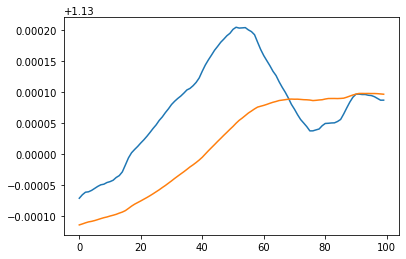

In [44]:
plt.plot(short_wma_list)
plt.plot(long_wma_list)
plt.show()